# LGBM Model Building

In [1]:
import lightgbm as lgb
import optuna
import optuna.visualization as vis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm

In [5]:
df2 = pd.read_csv('murder-db-V2.csv')
df2.head(5)

,Agentype,Solved,Year,Month,Murder,VicAge,VicSex,VicRace,OffAge,OffSex,OffRace,Weapon,Relationship,Circumstance,VicCount,OffCount,Region
0,local,1,1976,3,1,48,male,unknown,68,male,black,handgun,unknown,other argument,1,1,west
1,local,1,1976,4,1,33,female,white,44,male,white,handgun,girlfriend,other argument,1,1,west
2,local,1,1976,6,1,38,male,white,27,male,black,handgun,stranger,other,1,1,west
3,local,1,1976,6,1,41,male,white,34,male,white,handgun,other,other argument,1,1,west
4,local,1,1976,7,1,33,male,indian,37,female,indian,sharp object,brother,other argument,1,1,west


feature_names=Agentype Year Month Murder VicAge VicSex VicRace Weapon Relationship Circumstance VicCount Region

In [6]:
df2 = df2[['Agentype','Solved', 'Year', 'Month', 'Murder', 
           'VicAge', 'VicSex', 'VicRace', 'Weapon', 
           'Relationship', 'Circumstance', 'VicCount', 'Region']]
df2.head(5)

,Agentype,Solved,Year,Month,Murder,VicAge,VicSex,VicRace,Weapon,Relationship,Circumstance,VicCount,Region
0,local,1,1976,3,1,48,male,unknown,handgun,unknown,other argument,1,west
1,local,1,1976,4,1,33,female,white,handgun,girlfriend,other argument,1,west
2,local,1,1976,6,1,38,male,white,handgun,stranger,other,1,west
3,local,1,1976,6,1,41,male,white,handgun,other,other argument,1,west
4,local,1,1976,7,1,33,male,indian,sharp object,brother,other argument,1,west


In [7]:
df2.shape

(861234, 13)

In [8]:
categorical_columns = df2.select_dtypes(include = ['object']).columns.to_list()
df2[categorical_columns] = df2[categorical_columns].astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861234 entries, 0 to 861233
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Agentype      861234 non-null  category
 1   Solved        861234 non-null  int64   
 2   Year          861234 non-null  int64   
 3   Month         861234 non-null  int64   
 4   Murder        861234 non-null  int64   
 5   VicAge        861234 non-null  int64   
 6   VicSex        861234 non-null  category
 7   VicRace       861234 non-null  category
 8   Weapon        861234 non-null  category
 9   Relationship  861234 non-null  category
 10  Circumstance  861234 non-null  category
 11  VicCount      861234 non-null  int64   
 12  Region        859709 non-null  category
dtypes: category(7), int64(6)
memory usage: 45.2 MB


In [9]:
X = df2.drop(columns = 'Solved')
y = df2['Solved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((688987, 12), (172247, 12), (688987,), (172247,))

In [10]:
# Train and evaluate using default parameters
baseline_model = lgb.LGBMClassifier()
baseline_model.fit(X_train, y_train)
baseline_p = baseline_model.predict(X_test)

[LightGBM] [Info] Number of positive: 488781, number of negative: 200206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 688987, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709420 -> initscore=0.892568
[LightGBM] [Info] Start training from score 0.892568


In [11]:
precision_test = metrics.precision_score(y_test, baseline_p)
recall_test = metrics.recall_score(y_test, baseline_p) 
f1_test = metrics.f1_score(y_test, baseline_p)
accuracy_test = metrics.accuracy_score(y_test, baseline_p)
roc_auc_test = metrics.roc_auc_score(y_test, baseline_p)

print('The precision score is {pt:.4f}'.format(pt = precision_test))
print('The recall score is {rt:.4f}'.format(rt = recall_test))
print('The accuracy score is {at:.4f}'.format(at = accuracy_test))
print('The F1 score is {ft:.4f}'.format(ft = f1_test))
print('The AUC score is {auc:.4f}'.format(auc = roc_auc_test))

The precision score is 0.9433
The recall score is 0.8872
The accuracy score is 0.8822
The F1 score is 0.9144
The AUC score is 0.8785


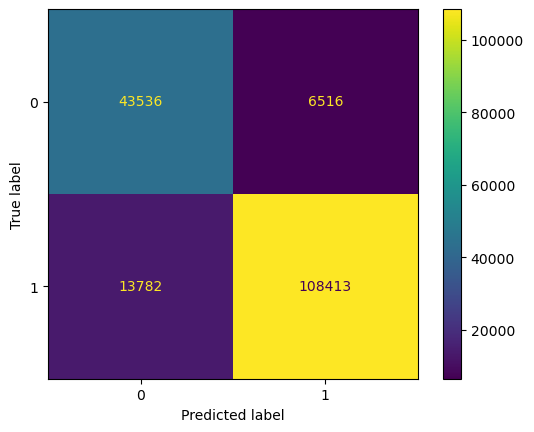

In [12]:
baseline_cm = confusion_matrix(y_test, baseline_p)
baseline_disp = ConfusionMatrixDisplay(confusion_matrix = baseline_cm)
baseline_disp.plot(values_format = '') 
plt.show()

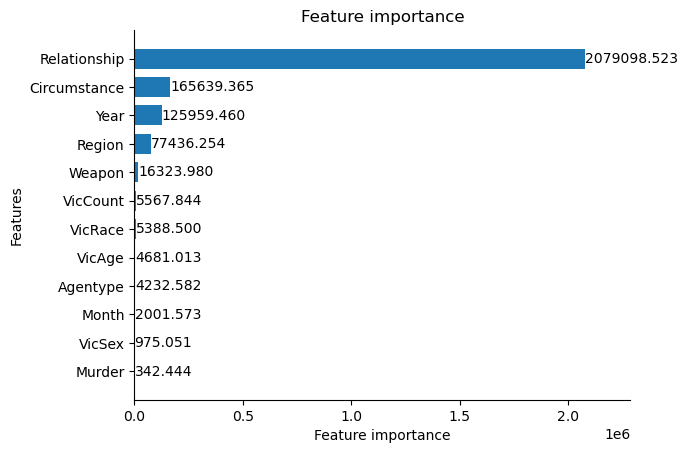

In [13]:
lgb.plot_importance(baseline_model, height = 0.7, importance_type = 'gain', grid = False)
sns.despine()
plt.show()

In [14]:
# Define the objective function
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "mse",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step = 0.01),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step = 100)}

    
    model_app = lgb.LGBMClassifier(**params)
    model_app.fit(X_train, y_train)
    predictions = model_app.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [15]:
# Run the optimization
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)

[I 2024-11-04 15:32:00,659] A new study created in memory with name: no-name-cf68b4b5-2172-4307-9c0e-9461f9cf0dce
[I 2024-11-04 15:32:10,270] Trial 0 finished with value: 0.11796431868189286 and parameters: {'learning_rate': 0.3, 'num_leaves': 882, 'max_depth': 9, 'colsample_bytree': 0.5797571330494964, 'min_data_in_leaf': 9900}. Best is trial 0 with value: 0.11796431868189286.
[I 2024-11-04 15:32:16,344] Trial 1 finished with value: 0.12526778405429412 and parameters: {'learning_rate': 0.23, 'num_leaves': 827, 'max_depth': 7, 'colsample_bytree': 0.16862820344604187, 'min_data_in_leaf': 2800}. Best is trial 0 with value: 0.11796431868189286.
[I 2024-11-04 15:32:22,818] Trial 2 finished with value: 0.11909060825442533 and parameters: {'learning_rate': 0.12, 'num_leaves': 362, 'max_depth': 6, 'colsample_bytree': 0.8537096858369654, 'min_data_in_leaf': 7200}. Best is trial 0 with value: 0.11796431868189286.
[I 2024-11-04 15:32:28,775] Trial 3 finished with value: 0.1200717574181263 and pa

[I 2024-11-04 15:37:30,153] Trial 31 finished with value: 0.11552015419717035 and parameters: {'learning_rate': 0.28, 'num_leaves': 694, 'max_depth': 10, 'colsample_bytree': 0.6249344076297997, 'min_data_in_leaf': 200}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:37:42,229] Trial 32 finished with value: 0.11643744158098544 and parameters: {'learning_rate': 0.24000000000000002, 'num_leaves': 691, 'max_depth': 10, 'colsample_bytree': 0.5683192572612488, 'min_data_in_leaf': 900}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:37:54,686] Trial 33 finished with value: 0.11622843939226808 and parameters: {'learning_rate': 0.28, 'num_leaves': 809, 'max_depth': 10, 'colsample_bytree': 0.4293246968147956, 'min_data_in_leaf': 200}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:38:05,771] Trial 34 finished with value: 0.11656516514075717 and parameters: {'learning_rate': 0.26, 'num_leaves': 866, 'max_depth': 9, 'colsample_bytree': 0.

[I 2024-11-04 15:42:20,786] Trial 61 finished with value: 0.11588010241107247 and parameters: {'learning_rate': 0.27, 'num_leaves': 530, 'max_depth': 10, 'colsample_bytree': 0.7369978271262606, 'min_data_in_leaf': 200}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:42:29,768] Trial 62 finished with value: 0.11690769650559951 and parameters: {'learning_rate': 0.26, 'num_leaves': 621, 'max_depth': 10, 'colsample_bytree': 0.6754664530054395, 'min_data_in_leaf': 900}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:42:39,467] Trial 63 finished with value: 0.1166464437697028 and parameters: {'learning_rate': 0.3, 'num_leaves': 312, 'max_depth': 10, 'colsample_bytree': 0.704366202956401, 'min_data_in_leaf': 1300}. Best is trial 31 with value: 0.11552015419717035.
[I 2024-11-04 15:42:48,777] Trial 64 finished with value: 0.11628068993944742 and parameters: {'learning_rate': 0.29000000000000004, 'num_leaves': 470, 'max_depth': 10, 'colsample_bytree': 0.8

[I 2024-11-04 15:46:52,414] Trial 91 finished with value: 0.11643163596463219 and parameters: {'learning_rate': 0.3, 'num_leaves': 581, 'max_depth': 10, 'colsample_bytree': 0.772175168729749, 'min_data_in_leaf': 600}. Best is trial 74 with value: 0.11545048680093122.
[I 2024-11-04 15:47:02,550] Trial 92 finished with value: 0.11576979570036053 and parameters: {'learning_rate': 0.29000000000000004, 'num_leaves': 605, 'max_depth': 10, 'colsample_bytree': 0.7165196060991131, 'min_data_in_leaf': 200}. Best is trial 74 with value: 0.11545048680093122.
[I 2024-11-04 15:47:12,654] Trial 93 finished with value: 0.11619360569414852 and parameters: {'learning_rate': 0.28, 'num_leaves': 522, 'max_depth': 10, 'colsample_bytree': 0.7133573444164909, 'min_data_in_leaf': 200}. Best is trial 74 with value: 0.11545048680093122.
[I 2024-11-04 15:47:22,178] Trial 94 finished with value: 0.11598460350543116 and parameters: {'learning_rate': 0.29000000000000004, 'num_leaves': 564, 'max_depth': 10, 'colsamp

In [17]:
# Get the best hyperparameters
print('Best hyperparameters:', study.best_params)
print('Best MSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.29000000000000004, 'num_leaves': 433, 'max_depth': 10, 'colsample_bytree': 0.7462277673564042, 'min_data_in_leaf': 200}
Best MSE: 0.11545048680093122


In [18]:
best_params = study.best_params
model_app = lgb.LGBMClassifier(**best_params, verbose = -1)
model_app.fit(X_train, y_train)
preds = model_app.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     50052
           1       0.94      0.89      0.92    122195

    accuracy                           0.88    172247
   macro avg       0.85      0.88      0.86    172247
weighted avg       0.89      0.88      0.89    172247



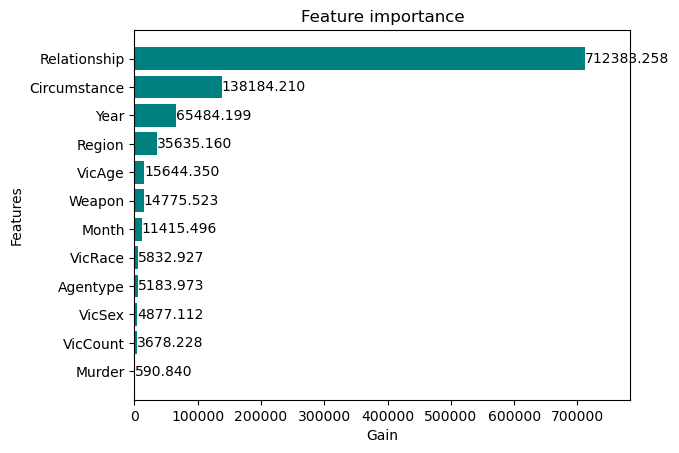

In [31]:
# View feature importance
lgb.plot_importance(model_app, height = 0.8, xlabel = 'Gain', importance_type = 'gain', 
                    grid = False, color = 'teal')

plt.show()


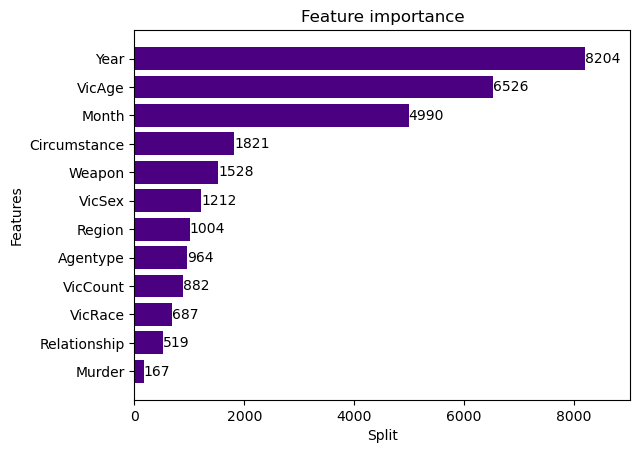

In [26]:
# View feature importance
lgb.plot_importance(model_app, height = 0.8, xlabel = 'Split', importance_type = 'split', 
                    grid = False, color = 'indigo')


plt.show()

In [29]:
pickle.dump(model_app, open('model_app.pkl', 'wb'))


In [30]:
pickled_model_app = pickle.load(open('model_app.pkl', 'rb'))


In [36]:
# List locally imported modules
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
        print("{}=={}".format(*r))

lightgbm==4.5.0
matplotlib==3.7.2
numpy==1.23.5
optuna==4.0.0
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2
tqdm==4.66.5


In [37]:
# Get the list of packages
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'lightgbm',
 'optuna',
 'optuna.visualization',
 'numpy',
 'pandas',
 'matplotlib.pyplot',
 'seaborn',
 'sklearn.metrics',
 'pickle',
 'pkg_resources',
 'types']